# 03 Modelling

**The objective of this notebook is to generate a linear regression model using selected numeric, ordinal, and nominal features.**

## Import Libraries

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression,  Ridge

from sklearn.metrics import mean_squared_error

In [160]:
# apply a plot style
plt.style.use('bmh')

## Read The Datasets

In [135]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [141]:
print(train.shape)
print(test.shape)

(1538, 82)
(513, 81)


## Preprocessing Data

- apply preprocessing() to train dataframe to clean the data
- trim down the dataframe to only contain selected numeric, nominal, and ordinal features

In [138]:
def preprocessing(df):
    ''' This function takes in a dataframe containing the Ames Housing dataset and preprocess it for regression models.'''

    #There are 2 outliers identified in EDA based on scatterplot of 'Gr Liv Area' vs. "SalePrice".
    #Drop these outliers
    drop_rows_GrLivArea_outliers = df[(df['Gr Liv Area'] > 4000)].index
    df = df.drop(drop_rows_GrLivArea_outliers, axis =0)
        
    #NUMERIC DATA TYPES
    # Creating 'porch_deck_sqft' by summing all porch and deck square footage columns
    porch_and_deck_features = ['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch', '3Ssn Porch']
    df['porch_deck_sqft'] = df[porch_and_deck_features].sum(axis=1)
    
    # Creating 'all_baths_count' by summing all types of bathrooms
    bath_features = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Full Bath']
    df['all_baths_count'] = df[bath_features].sum(axis=1)
    
    # fill in missing values in the following numeric features with 0
    df['Total Bsmt SF'].fillna(0, inplace = True)
    df['Mas Vnr Area'].fillna(0, inplace = True)
    df['Garage Cars'].fillna(0, inplace = True)
    df['Garage Area'].fillna(0, inplace = True)
    
    
    #go through the dataframe, and if there is a missing value in "Lot Frontage", fill in with the mean of "Lot Frontage" that is groupby "Neighborhood"
    df['Lot Frontage'] = df.groupby("Neighborhood")['Lot Frontage'].transform(lambda value : value.fillna(value.mean()))
    #if there are still NaN values, just drop the row:
    df.dropna(subset=['Lot Frontage'], inplace=True)   
    
    #STRING OBJECT DATA TYPES
    # fill in NaNs in "Mas Vnr Type", which records the masonry veneer type (nominal), and one of the options is "None".
    df['Mas Vnr Type'].fillna('None', inplace = True)
    
    # Fill in the NaNs in categorical garage features with "No Garage"
    df['Garage Qual'].fillna('NA', inplace = True)
    
    # Fill in the NaNs in categorical ordinal "Bsmt Qual" features with "No Garage"
    df["Bsmt Qual"].fillna('NA', inplace = True)

    return df

In [139]:
train_preprocessed = preprocessing(train)
train_trimmed = train_preprocessed[numeric_features + nominal_features + ordinal_features + ['SalePrice']]
train_trimmed.head()

,Gr Liv Area,Total Bsmt SF,Garage Cars,Garage Area,Year Built,Year Remod/Add,TotRms AbvGrd,Mas Vnr Area,Fireplaces,Lot Frontage,...,Overall Qual,Overall Cond,Exter Qual,Bsmt Qual,Heating QC,Kitchen Qual,Functional,Electrical,Garage Qual,SalePrice
0,1587,1587.0,2.0,525.0,1971,1971,7,302.0,1,85.000000,...,6,6,TA,TA,TA,TA,Typ,SBrkr,TA,167300
1,2267,1005.0,2.0,498.0,1937,1980,7,0.0,2,107.000000,...,7,8,TA,TA,TA,TA,Typ,SBrkr,TA,219000
2,864,864.0,2.0,720.0,1950,2002,5,0.0,0,60.000000,...,5,8,TA,TA,Gd,Gd,Typ,SBrkr,TA,129000
3,2260,1306.0,2.0,533.0,1996,1997,7,0.0,0,80.000000,...,7,5,Gd,Ex,Ex,Gd,Typ,SBrkr,TA,328000
4,2501,1242.0,3.0,751.0,1995,1995,9,466.0,1,88.733333,...,8,7,Gd,Gd,Ex,Gd,Typ,SBrkr,TA,290000


In [140]:
train_trimmed.isnull().sum()

Gr Liv Area        0
Total Bsmt SF      0
Garage Cars        0
Garage Area        0
Year Built         0
Year Remod/Add     0
TotRms AbvGrd      0
Mas Vnr Area       0
Fireplaces         0
Lot Frontage       0
Lot Area           0
porch_deck_sqft    0
all_baths_count    0
Neighborhood       0
MS Zoning          0
Bldg Type          0
Mas Vnr Type       0
House Style        0
Foundation         0
Sale Type          0
Overall Qual       0
Overall Cond       0
Exter Qual         0
Bsmt Qual          0
Heating QC         0
Kitchen Qual       0
Functional         0
Electrical         0
Garage Qual        0
SalePrice          0
dtype: int64

## Feature Engineering

In [142]:
#separate the train set data into X features and y target
X = train_trimmed.drop(['SalePrice'], axis =1)
y = train_trimmed['SalePrice']

In [143]:
# split up X and y into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [144]:
# verify that the shapes are ok
print(X_train.shape)
print(y_train.shape)

(1149, 29)
(1149,)


### Transformer and Pipeline

In [145]:
# scale numeric_features using PolynomialFeatures & MinMaxScaler()
numeric_transformer = Pipeline(steps=[('poly', PolynomialFeatures(degree=2, include_bias = False)),
                                      ('scaler', MinMaxScaler())])

# encode nominal_features using OneHotEncoder
nominal_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))
                                     ])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=list(ordinal_features_dict.values()))), 
    ('scaler', MinMaxScaler())])

# use ColumnTransformer to transform each feature based on the type (numeric, nominal, or ordinal)
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('nominal', nominal_transformer, nominal_features),
        ('ordinal', ordinal_transformer, ordinal_features) ])

### TransformTargetRegressor and Pipeline

In [146]:
# our function is log
# our inverse function is np.exp
ttr_ridge_model = TransformedTargetRegressor(Ridge(), func = np.log, inverse_func = np.exp)

In [175]:
# Combine into a complete pipeline
ridge_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                             ('ttr_ridge_model', ttr_ridge_model)])

In [148]:
ridge_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Gr Liv Area',
                                                   'Total Bsmt SF',
                                                   'Garage Cars', 'Garage Area',
                                                   'Year Built',
                                                   'Year Remod/Add',
                                                   'TotRms AbvGrd',
                                                   'Mas Vnr Area', 'Fireplaces',
                                                   'Lot Frontage', 'Lot Area',
                                                   'porch_deck_sqft',
                                                   'all_baths_count'])...
                                                                                               'Min1',
                                                                                               'Typ'],
                                                                                              ['Mix',
                                                                                               'FuseP',
                                                                                               'FuseF',
                                                                                               'FuseA',
                                                                                               'SBrkr'],
                                                                                              ['NA',
                                                                                               'Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex']])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Overall Qual',
                                                   'Overall Cond', 'Exter Qual',
                                                   'Bsmt Qual', 'Heating QC',
                                                   'Kitchen Qual', 'Functional',
                                                   'Electrical',
                                                   'Garage Qual'])])),
                ('ttr_ridge_model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge()))])

### Hyperparameter tuning with GridSearchCV

In [149]:
# Using GridSearchCV for hyperparameter tuning
#params for ridge & polynomialfeatures
param_grid = {
    'ttr_ridge_model__regressor__alpha': [0.001, 0.1, 1]}

gridsearchcv = GridSearchCV(estimator=ridge_pipe,
                            param_grid=param_grid,
                            cv=5,
                            scoring='r2',
                            error_score='raise',
                            verbose=1)

In [150]:
gridsearchcv

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Gr '
                                                                          'Liv '
                                                                          'Area',
                                                                          'Total '
                                                                          'Bsmt '
                                                                          'SF',
                                                                          'Garage '
                                                                          'Cars',
                                                                          'Garage '
                                                                          'Area',
                                                                          'Year '
                                                                          'Built',
                                                                          'Year '
                                                                          'Remod/Add',
                                                                          'TotRms '
                                                                          'AbvGrd',
                                                                          'Mas '
                                                                          'Vnr '
                                                                          'Area',
                                                                          'Fir...
                                                                                          MinMaxScaler())]),
                                                                         ['Overall '
                                                                          'Qual',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Exter '
                                                                          'Qual',
                                                                          'Bsmt '
                                                                          'Qual',
                                                                          'Heating '
                                                                          'QC',
                                                                          'Kitchen '
                                                                          'Qual',
                                                                          'Functional',
                                                                          'Electrical',
                                                                          'Garage '
                                                                          'Qual'])])),
                                       ('ttr_ridge_model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                          

In [151]:
#fit gridsearchcv to train set:
gridsearchcv.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


### check model parameters & evaluate model

In [155]:
# use the grid_model to make predictions using X_test_scaled
# note that this is still a subset of train.csv and not the test.csv
y_predictions = gridsearchcv.predict(X_test)
# y_predictions

In [156]:
print("Best parameters:", gridsearchcv.best_params_)
print("Best R^2 score:", gridsearchcv.best_score_)

Best parameters: {'ttr_ridge_model__regressor__alpha': 1}
Best R^2 score: 0.9239076832137627


In [161]:
# RMSE and average SalePrice
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_predictions)))
print('Average SalePrice:', np.mean(train['SalePrice']))

RMSE: 20379.55073159024
Average SalePrice: 181061.9934980494


## Regression Model Plot

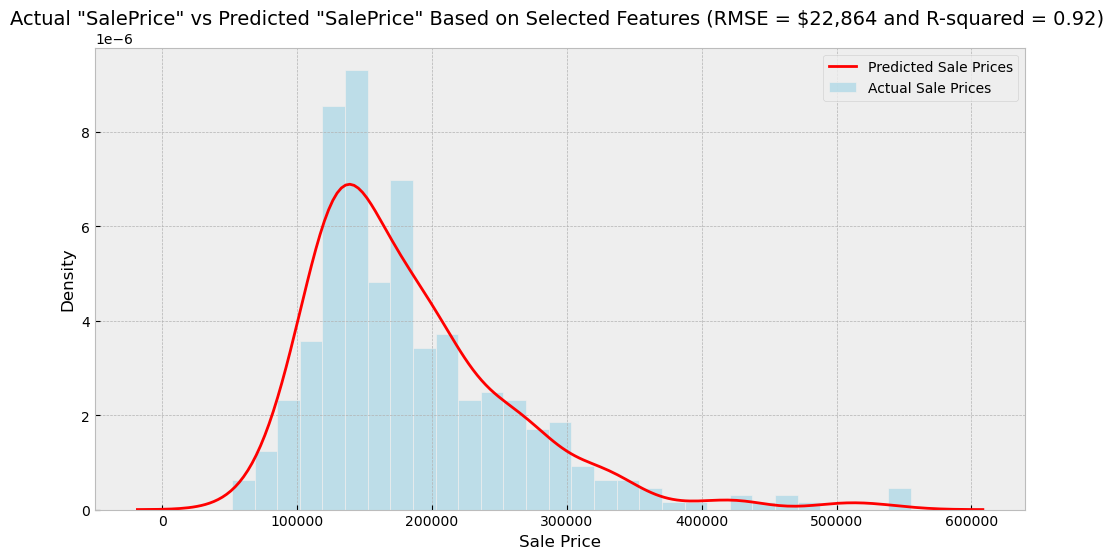

In [174]:
# Create a histogram of the actual sale prices
plt.figure(figsize=(12,6))
sns.histplot(y_test, bins=30, kde=False, color='lightblue', label='Actual Sale Prices', stat="density")

# Plot the predicted sale prices as a density plot (smooth curve)
sns.kdeplot(y_predictions, color='red', label='Predicted Sale Prices')

# Adding labels and legend
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Actual "SalePrice" vs Predicted "SalePrice" Based on Selected Features (RMSE = $22,864 and R-squared = 0.92) ', fontsize = 14)
plt.legend()

plt.savefig('../images/Actual_salePrice_vs_Prediction_All_Features.png', dpi=300)
plt.show()

## Making Predictions on 'test.csv' for kaggle competition

- In order to make predictions on 'test.csv', I need to process the dataframe to use as input to the model.
- apply preprocessing() to train dataframe to clean the data
- trim down the dataframe to only contain selected numeric, nominal, and ordinal features
- Note that there is no "SalePrice" in the test.csv

In [165]:
test_preprocessed = preprocessing(test)
test_trimmed = test_preprocessed[numeric_features + nominal_features + ordinal_features]
test_trimmed.shape

(513, 29)

In [166]:
#verify that there are no nulls:
test_trimmed.isnull().sum()

Gr Liv Area        0
Total Bsmt SF      0
Garage Cars        0
Garage Area        0
Year Built         0
Year Remod/Add     0
TotRms AbvGrd      0
Mas Vnr Area       0
Fireplaces         0
Lot Frontage       0
Lot Area           0
porch_deck_sqft    0
all_baths_count    0
Neighborhood       0
MS Zoning          0
Bldg Type          0
Mas Vnr Type       0
House Style        0
Foundation         0
Sale Type          0
Overall Qual       0
Overall Cond       0
Exter Qual         0
Bsmt Qual          0
Heating QC         0
Kitchen Qual       0
Functional         0
Electrical         0
Garage Qual        0
dtype: int64

In [171]:
# make predictions by fitting the gridsearchcv model to test_trimmed dataframe
test_preds = gridsearchcv.predict(test_trimmed)

# first 10 predictions look accurate.
test_preds[:10]

array([122155.26839502, 223300.74290709, 272555.76908134, 123257.84091444,
       208323.14995856, 364828.40224729, 160461.84141782, 281936.97266037,
       158538.79300405,  83114.28848129])

In [86]:
#verify that the number of rows are the same:
print(test_trimmed.shape)
print(test_preds.shape)

(513, 29)
(513,)


In [173]:
# add "Unnamed: 0" column along with the "SalePrice" predictions.
kaggle_submission_5_polyminmax_params = pd.DataFrame({
    'Unnamed: 0': test['Unnamed: 0'],
    'SalePrice': test_preds
}).set_index('Unnamed: 0')

# save to csv for the kaggle submittion
kaggle_submission_5_polyminmax_params.to_csv('../datasets/an_kaggle_submission_5_polyminmax_params.csv')